In [1]:
import pandas as pd

In [10]:
df_attributes = pd.read_csv('/srv/celeba/list_attr_celeba.txt', sep='\s+')
df_attributes.head()

,file,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [8]:
df_celebrities = pd.read_csv('/srv/celeba/identity_CelebA.txt', sep='\s+')
df_celebrities.head()

,file,celebrity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [16]:
df = df_attributes.join(df_celebrities, lsuffix='', rsuffix='_other').drop('file_other', axis=1)
df.head()

,file,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,celebrity
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,2880
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2937
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,8692
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,5805
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,9295


In [23]:
df.loc[:, df.columns != 'file'] = df.loc[:, df.columns != 'file'].applymap(lambda x: 0 if x == -1 else x)
df.head()

,file,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,celebrity
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,2880
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,2937
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,8692
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,5805
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,9295


<AxesSubplot:>

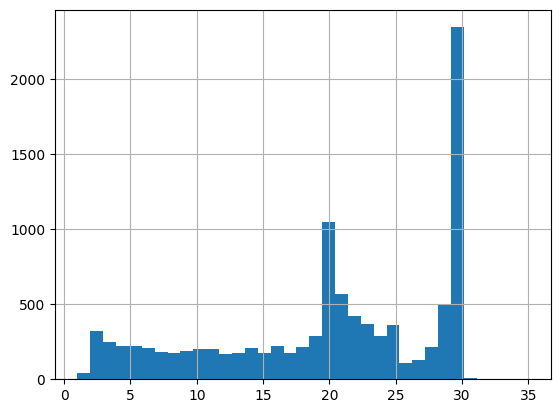

In [37]:
df_celebrities['celebrity'].value_counts().hist(bins=35)

In [68]:
df_attractiveness = df[['celebrity', 'Attractive']].groupby('celebrity').aggregate(
    count=pd.NamedAgg(column="Attractive", aggfunc="count"),
    total=pd.NamedAgg(column="Attractive", aggfunc="sum")
)

df_attractiveness['attractiveness'] = df_attractiveness.apply(lambda row: row['total'] / row['count'], axis=1)
df_attractiveness = df_attractiveness.drop(['count', 'total'], axis=1).sort_values(by='attractiveness')
df_attractiveness

,attractiveness
celebrity,
9207,0.0
2294,0.0
5396,0.0
2298,0.0
2301,0.0
...,...
8116,1.0
4227,1.0
4238,1.0
